In [1]:
from dataset import VocDataset
from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
from config import opt

%matplotlib inline

## check dataset

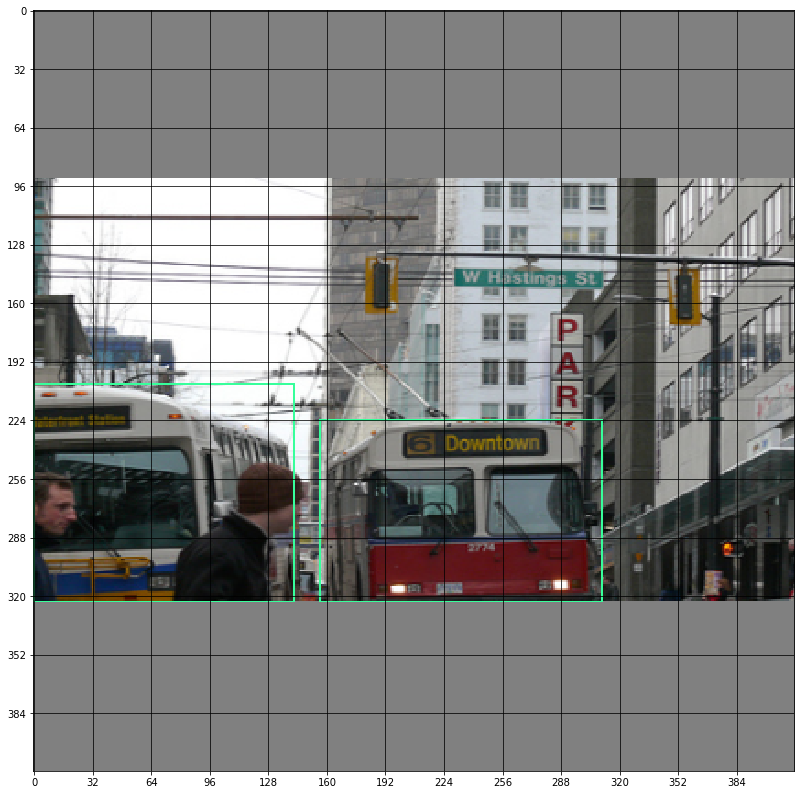

[8 7]
5
resized_bbox: [323.60599572 310.88650964 224.72805139 156.77944325]
xywh [7.30728051 8.56771949 4.81584582 3.08993576]
[323.60599571734474, 310.8865096359743, 224.72805139186292, 156.77944325481798]
[[  0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.      ]
 [233.83298  274.16702  154.10707   98.877945   1.         0.
    0.         0.         0.         0.         1.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.      ]
 [  0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.      ]
 [  0. 

In [2]:
vd = VocDataset(show_img=True, is_train=True)
img, target = vd[6]
print(vd.grid_idx[0])
print(vd.grid_labels[0])
print('resized_bbox:', vd.resized_bboxes[0])
print('xywh', vd.xywh[0] / 32)
for xywh in vd.xywh[0:1]:
    xmin = xywh[0] - xywh[2] / 2
    ymin = xywh[1] - xywh[3] / 2
    xmax = xywh[0] + xywh[2] / 2
    ymax = xywh[1] + xywh[3] / 2
    print([ymax, xmax, ymin, xmin])

for id in vd.grid_idx[0:1]:
    print(target[id[0], id[1]])


a = np.arange(13)
b = np.arange(13)
x, y = np.meshgrid(a, b)
xy_offset = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis=-1).reshape(13, 13, 2)
print(xy_offset[vd.grid_idx[0][0], vd.grid_idx[0][1]])

In [3]:
device = 'cpu'
img_size = [416, 416]
class_num = 20
coord_scale = 1.0
class_scale = 1.0
noobj_scale = 1.0
obj_scale = 5.0
batch_size = 32
num_workers = 4

In [18]:
VocTrainDataLoader = DataLoader(VocDataset(is_train=True), batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers, drop_last=True)
VocTestDataLoader = DataLoader(VocDataset(is_train=False), batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers, drop_last=True)

testDataset = VocDataset(is_train=False)

## build net

In [5]:
from yolonet import Backbone

yolov2 = Backbone().to(device)

Initialize model's weights ...


## initilize optimizer

In [6]:
params = [{'params': yolov2.pth_layer.parameters(), 'lr': opt.pth_lr},
          {'params': yolov2.yolo_layer.parameters(), 'lr': opt.yolo_lr}]
if opt.optimizer_type == 'SGD':
    optimizer = torch.optim.SGD(params=params, lr=opt.lr,  momentum=opt.optimizer_momentum,
                                weight_decay=opt.optimizer_weight_decay)
else:
    optimizer = torch.optim.Adam(params=params, lr=opt.lr, weight_decay=opt.optimizer_weight_decay)

## load anchors

In [7]:
from anchor_utils import parse_anchors
anchors = torch.from_numpy(parse_anchors(opt.anchors_path)).to(device)

print(anchors)

tensor([[ 42.3072,  55.4064],
        [102.1680, 128.3021],
        [161.7878, 259.1654],
        [303.0758, 154.8970],
        [359.5648, 320.2272]])


## loss functions

### bbox_iou

In [8]:
from box_utils import xywh2xyxy

def bbox_iou(bbox1, bbox2):
    """
    :param bbox1:
        [13, 13, 5, 4] / [x, y, w, h];
    :param bbox2:
        [13, 13, 5, 4] / [x, y, w, h];
    :return:
        [13, 13, 5];
    """
    # assert bbox1.shape == bbox2.shape
    bbox2 = xywh2xyxy(bbox2)
    bbox1 = xywh2xyxy(bbox1)
    # [13, 13, 5, 2] -> [13, 13, 5]
    bbox1_area = torch.prod(bbox1[..., [0, 1]] - bbox1[..., [2, 3]], dim=-1)
    bbox2_area = torch.prod(bbox2[..., [0, 1]] - bbox2[..., [2, 3]], dim=-1)

    # [13, 13, 5] & [13, 13, 5] -> [13, 13, 5]
    intersection_xmin = torch.max(bbox1[..., 0], bbox2[..., 0])
    intersection_ymin = torch.max(bbox1[..., 1], bbox2[..., 1])
    intersection_xmax = torch.min(bbox1[..., 2], bbox2[..., 2])
    intersection_ymax = torch.min(bbox1[..., 3], bbox2[..., 3])
    # [13, 13, 5] & [13, 13, 5] -> [13, 13, 5]
    intersection_w = torch.max(intersection_xmax - intersection_xmin, torch.tensor(0., device=device))
    intersection_h = torch.max(intersection_ymax - intersection_ymin, torch.tensor(0., device=device))
    intersection_area = intersection_w * intersection_h
    # [13, 13, 5] & ([13, 13, 5] & [13, 13, 5] & [13, 13, 5]) -> [13, 13, 5]
    ious = intersection_area / (bbox1_area + bbox2_area - intersection_area + 1e-10)
    # ious shape: [13, 13, 5]
    return ious

### reorg_layer

In [9]:
def reorg_layer(preds, anchors):
    """
    :param preds:
        [N, 13, 13, 125]
    :param anchors:
        [[w, h], ,,,]
        注意：kmeans得到anchors的w,h是相对于输入图片的scale的(也就是416)，论文中的p_w,p_h是相对于feature map大小的，
        计算loss时需要先将anchor的scale转换到feature map的scale
    :return:
        bboxes: [batch_size, 13, 13, 5, 4]
        confs_logit: [batch_size, 13, 13, 5, 1]
        classes_logit: [batch_size, 13, 13, 5, 20]
    """
    # grid_size format is [h,w]
    grid_size = [preds.size(1), preds.size(2)]

    # ratio: feature map与输入图片的缩放比
    # ratio format is [h,w]
    ratio = torch.tensor([img_size[0], img_size[1]]) / torch.tensor(grid_size, dtype=torch.float32)
    ratio = ratio.to(device)
    # rescaled_anchors format is [w,h] / make anchors's scale same as predicts
    rescaled_anchors = (anchors / ratio.flip(0)).to(device)
    # resahpe preds to [N, 13, 13, 5, 25]
    preds = preds.reshape(-1, grid_size[0], grid_size[1], opt.B, preds.size(-1) // opt.B)

    # box_xy: [N, 13, 13, 5, 2] / format [x, y]
    # box_wh: [N, 13, 13, 5, 2] / format [w, h]
    # confs: [N, 13, 13, 5, 1]
    # classes: [N, 13, 13, 5, 20]
    box_xy, box_wh, confs_logit, classes_logit = torch.split(preds, [2, 2, 1, class_num], dim=-1)
    box_xy = torch.sigmoid(box_xy)
    grid_x = np.arange(grid_size[1], dtype=np.float32)
    grid_y = np.arange(grid_size[0], dtype=np.float32)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)

    xy_offset = np.concatenate([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)], axis=-1)
    # xy_offset: [13, 13, 1, 2]
    xy_offset = torch.from_numpy(xy_offset).to(torch.float32).to(device)
    xy_offset = xy_offset.contiguous().view(grid_size[1], grid_size[0], 1, 2)

    # rescale to input_image scale
    box_xy = (box_xy + xy_offset) * ratio.flip(0)
    # rescale to input_image scale
    box_wh = torch.exp(box_wh) * rescaled_anchors
    # avoid getting Nan
    box_wh = torch.clamp_min(box_wh, 1e-7)
    box_wh = box_wh * ratio.flip(0)

    # reset scaled pred_box to bounding box format [x, y, w, h]
    # bboxes: [N, 13, 13, 5, 4]
    bboxes = torch.cat([box_xy, box_wh], dim=-1)

    return xy_offset, bboxes, confs_logit, classes_logit

### compute_loss

In [10]:
def compute_loss(preds, ground_truth, anchors):
    """
    class loss使用cross entropy
    :param preds:
        [batch_size, 13, 13, 125]
    :param ground_truth:
        [batch_size, 13, 13, 5, 25]
    :return:
    """
    # grid_size format is [h, w]
    grid_size = [preds.size(1), preds.size(2)]
    # ratio's format is [h, w]
    ratio = torch.tensor([img_size[0] / grid_size[0], img_size[1] / grid_size[1]], dtype=torch.float32)
    ratio = ratio.to(device)

    xy_offset, pred_bboxes, pred_confs, pred_classes = reorg_layer(preds, anchors)
    # [batch_size, 13, 13, 5, 4] & [batch_size, 13, 13, 5, 4] -> [batch_size, 13, 13, 5]
    iou_pred_gt = bbox_iou(pred_bboxes, ground_truth[..., :4])
    # pred_xy: [batch_size, 13, 13, 5, 2]
    # pred_xy's and label_xy's format is [w, h]
    # 因为pred_bboxes经过reorg_layer处理后rescale到了input_img的scale,在计算loss时需要把pred_xy的scale缩放到grid的scale
    pred_txty = pred_bboxes[..., 0:2] / ratio.flip((0, )) - xy_offset
    true_txty = ground_truth[..., 0:2] / ratio.flip((0, )) - xy_offset
    # pred_wh: [batch_size, 13, 13, 5, 2]
    # 这里除以anchor是因为reorg_layer函数处理后对predict_bbox_wh乘以了scale为416的anchor，这里只是还原模型最初输出的预测值
    pred_twth = pred_bboxes[..., 2:4] / anchors
    true_twth = ground_truth[..., 2:4] / anchors
    # for numercial stability
    # 防止等于0的值在进行对数运算时得到负无穷
    pred_twth[pred_twth == 0.] = 1.
    true_twth[true_twth == 0.] = 1.

    pred_twth = torch.clamp_min(pred_twth, min=1e-9)
    true_twth = torch.clamp_min(true_twth, min=1e-9)
    # 这里取对数是因为reorg_layer对pred_wh进行了exponential运算
    pred_twth = torch.log(pred_twth)
    true_twth = torch.log(true_twth)
    # [batch_size, 13, 13, 5, 4]
    pred_bbox = torch.cat([pred_txty, pred_twth], dim=-1)
    ground_truth[..., :4] = torch.cat([true_txty, true_twth], dim=-1)

    # conf_mask: [batch_size, 13, 13, 5]
    # coord_mask: [batch_size, 13, 13, 5, 1]
    # class_mask: [batch_size, 13, 13, 5]
    # target_confs: [batch_size, 13, 13, 5]
    # target_dxdy: [batch_size, 13, 13, 5, 2]
    # target_twth: [batch_size, 13, 13, 5, 2]
    # target_calsses: [batch_size, 13, 13, 5, 20]
    conf_mask, coord_mask, class_mask, target_confs, target_txty, target_twth, target_classes = build_targets(pred_bbox, ground_truth, iou_pred_gt)
    # conf_mask = torch.sqrt(conf_mask)

    mse = torch.nn.MSELoss(reduction='sum')
    ce = torch.nn.CrossEntropyLoss(reduction='sum')
    # dxdy_loss: [batch_size, 13, 13, 5, 2]
    dxdy_loss = mse(pred_txty[coord_mask], target_txty[coord_mask]) / batch_size
    # twth_loss: [batch_size, 13, 13, 5, 2]
    twth_loss = mse(pred_twth[coord_mask], target_twth[coord_mask]) / batch_size

    # [batch_szie, 13, 13, 5, 1] -> [batch_size, 13, 13, 5]
    pred_confs = pred_confs.sigmoid().squeeze(dim=-1)
    conf_loss = mse(pred_confs * conf_mask, target_confs * conf_mask) / batch_size

    target_classes = target_classes[class_mask].reshape(-1)  # [N,]
    pred_classes = pred_classes[class_mask].reshape(-1, class_num)  # [N, 20]
    class_loss = ce(pred_classes, target_classes) / batch_size
    total_loss = coord_scale * (dxdy_loss + twth_loss) + conf_loss + class_scale * class_loss

    loss_dict = {'total_loss': total_loss,
                 'dxdy_loss': opt.coord_scale * dxdy_loss,
                 'twth_loss': opt.coord_scale * twth_loss,
                 'conf_loss': conf_loss,
                 'class_loss': opt.class_scale * class_loss}

    return loss_dict

### build_target

In [11]:
from box_utils import yolov2_bbox_iou

def build_targets(pred_bbox, ground_truth, iou_pred_gt):
    """
    :param pred_bbox:
        [batch_size, 13, 13, 5, 4]
    :param ground_truth:
        [batch_size, 13, 13, 5, 25] / last dimension: [dx, dy, tw, th, conf, labels]
    :param iou_pred_gt:
        [batch_size, 13, 13, 5]
    :return:
    """
    grid_size = [pred_bbox.shape[1], pred_bbox.shape[2]]
    # [batch_size, 13, 13, 5]
    conf_mask = torch.ones(batch_size, grid_size[0], grid_size[1], opt.B, dtype=torch.float32, requires_grad=False, device=device) * noobj_scale
    coord_mask = torch.zeros(batch_size, grid_size[0], grid_size[1], opt.B, dtype=torch.bool, requires_grad=False, device=device)
    class_mask = torch.zeros(batch_size, grid_size[0], grid_size[1], opt.B, dtype=torch.bool, requires_grad=False, device=device)
    obj_conf = torch.zeros(batch_size, grid_size[0], grid_size[1], opt.B, dtype=torch.float32, requires_grad=False, device=device)
    obj_txty = torch.zeros(batch_size, grid_size[0], grid_size[1], opt.B, 2, dtype=torch.float32, requires_grad=False, device=device)
    obj_twth = torch.zeros(batch_size, grid_size[0], grid_size[1], opt.B, 2, dtype=torch.float32, requires_grad=False, device=device)
    obj_class = torch.zeros(batch_size, grid_size[0], grid_size[1], opt.B, dtype=torch.long, requires_grad=False, device=device)

    # [batch_size, 13, 13, 5]
    obj_mask = ground_truth[..., 4] > 0.

    for b in range(ground_truth.size(0)):
        # 每个cell的所有(5个)预测框与所有gt_bbox计算iou，最大iou值小于阈值的预测框标记为background并计算conf损失，最大iou大于阈值的cell不计入损失函数的计算
        # [M, 4]
        valid_bbox = ground_truth[b, ..., :4][obj_mask[b]]
        # [13, 13, 5, 4] & [M, 4] -> [13, 13, 5, M]
        iou_pred_valid = yolov2_bbox_iou(pred_bbox[b], valid_bbox, device=device)
        # [13, 13, 5]
        max_iou = torch.max(iou_pred_valid, dim=-1)[0]
        # [13, 13, 5] / bool
        tmp_mask = torch.ge(max_iou, 0.6)
        # 不包含目标的cell的所有预测框中，预测box和所有gt_box的iou小于0.6的计算conf损失；对于包含目标的cell的预测框的conf下面的code会进行处理
        conf_mask[b][tmp_mask] = 0.

        # 存在目标的cell中，最大iou对应的那个预测框负责预测并计算该预测框的bbox损失，conf损失以及分类损失
        coord_mask[b][obj_mask[b]] = 1
        class_mask[b][obj_mask[b]] = 1
        conf_mask[b][obj_mask[b]] = obj_scale

        obj_conf[b][obj_mask[b]] = iou_pred_gt[b][obj_mask[b]]
        obj_txty[b][obj_mask[b]] = ground_truth[b][obj_mask[b]][:, :2]
        obj_twth[b][obj_mask[b]] = ground_truth[b][obj_mask[b]][:, 2:4]
        # obj_class[b][obj_mask[b]] = ground_truth[b][obj_mask[b]][:, 5:]
        obj_class[b][obj_mask[b]] = torch.argmax(ground_truth[b][obj_mask[b]][:, 5:], dim=-1)

    return conf_mask, coord_mask, class_mask, obj_conf, obj_txty, obj_twth, obj_class

### adjust_lr

In [12]:
def adjust_lr(optimizer, epoch):

    def set_lr(optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    if opt.optimizer_type == 'SGD':
        if epoch < 15:
            set_lr(optimizer, 1e-5)
        elif 15 < epoch < 45:
            set_lr(optimizer, 1e-4)
        elif 45 < epoch < 115:
            set_lr(optimizer, 1e-6)
        else:
            set_lr(optimizer, opt.lr * 0.1 ** (epoch // 50))
    else:
        if epoch < 50:
            set_lr(optimizer, 1e-3)
        elif 50 <= epoch < 150:
            set_lr(optimizer, 1e-4)
        else:
            set_lr(optimizer, opt.lr * 0.05 ** (epoch // 30))

## training

### eval

In [19]:
from nms import nms
from plot_utils import plot_one

score_threshold = 0.3 
iou_threshold = 0.5
max_boxes_num = 100


def eval(yolov2, epoch, step, test_imgs, testDataset=testDataset):
    yolov2.eval()
    conf_list = []
    cls_list = []
    score_list = []
    steps = 0
    normailze = transforms.Compose([transforms.ToTensor(), transforms.Normalize(opt.mean, opt.std)])
    with torch.no_grad():
        for img_id in test_imgs:
            steps += 1
            resized_img, true_box, true_label = testDataset[img_id]
            img = normailze(resized_img)
            # [3, 416, 416] -> [1, 3, 416, 416]
            img = torch.unsqueeze(img, dim=0)
            img = img.to(device)
            preds = yolov2(img)
            boxes, confs, probs = predict(preds)

            boxes = boxes.squeeze(0)  # [13*13*5, 4]
            confs = confs.squeeze(0)  # [13*13*5, 1]
            probs = probs.squeeze(0)  # [13*13*5, 20]
            scores = (confs * probs).squeeze(0)  # [13*13*5, 20]
            conf_list.extend(confs.detach().cpu().numpy())
            cls_list.extend(probs.detach().cpu().numpy())
            score_list.extend(scores.detach().cpu().numpy())
            pred_dict = {'conf': conf_list[-1].flatten(), 'cls': cls_list[-1].flatten(), 'score': score_list[-1].flatten()}
        
            # box_out: [xmin, ymin, xmax, ymax]
            # nms(boxes, scores, score_threshold, iou_threshold, max_box_num, device, class_num, img_size)
            box_out, score_out, label_out = nms(boxes, scores, 0.3, 0.5, 100, device=device, class_num=20, img_size=416)

            plot_dict = {'img': resized_img,
                         'pred_box': box_out.cpu().numpy(),
                         'pred_score': score_out.cpu().numpy(),
                         'pred_label': label_out.cpu().numpy(),
                         'gt_box': true_box,
                         'gt_label': true_label,
                         'epoch': epoch,
                         'step': step,
                         'img_name': img_id,
                         'save_path': './'}

            plot_one(plot_dict)

    msg = f"\n" \
          f"Score Mean: {np.mean(score_list):.5f} \n" \
          f"Score Max: {np.max(score_list):.5f} \n" \
          f"Score Min: {np.min(score_list):.5f} \n" \
          f"Max conf: {np.max(conf_list)} \n" \
          f"Max cls: {np.max(cls_list)}"
    print(msg)

    yolov2.train()

### training

In [20]:
from torchnet.meter import AverageValueMeter
from tqdm import tqdm

yolov2.train()

loss_tmp = float('inf')
start_epoch = 0
total_steps = 0
loss_meter = AverageValueMeter()
data_length = len(VocDataset(is_train=True))
print('Train from stratch ...')

for epoch in range(start_epoch, 300):
    for i, (imgs, targets) in tqdm(enumerate(VocTrainDataLoader)):
        imgs, tragets = imgs.to(device), targets.to(device)
        
        img_size = torch.tensor([imgs.shape[2], imgs.shape[3]], dtype=torch.float32)
        # preds: [N, 13, 13, 125]
        preds = yolov2(imgs)
        loss_dict = compute_loss(preds, tragets, anchors)
        adjust_lr(optimizer, epoch)
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        loss_meter.add(loss_dict['total_loss'].item())
        
        total_steps += 1
        mean_loss = loss_meter.mean
        if total_steps % 2 == 0:
            message = f'Epoch[{epoch: 03}] Step[{(epoch * data_length + i + 1): 06}]]'
            print(message)
            print(f' Mean_loss : {mean_loss:.3f}')
            print(f' XY_loss   : {loss_dict["dxdy_loss"]:.3f}')
            print(f' WH_loss   : {loss_dict["twth_loss"]:.3f}')
            print(f' Conf_loss : {loss_dict["conf_loss"]:.3f}')
            print(f' Class_loss: {loss_dict["class_loss"]:.3f}')
            print(f' Total_loss: {loss_dict["total_loss"]:.3f}')
        if total_steps % opt.eval_step == 0:
            img_ids = [5, 7, 27]
            eval(yolov2, epoch, i + 1, img_ids)
        
        # self.trainer.save(epoch, mean_loss, opt.model_save_dir + f'/model_{total_steps % opt.save_every}.pkl')

Train from stratch ...




0it [00:00, ?it/s]

1it [00:15, 15.85s/it]

2it [00:30, 15.51s/it]

Epoch[ 00] Step[ 00002]]
 Mean_loss : 265.829
 XY_loss   : 0.347
 WH_loss   : 1.130
 Conf_loss : 252.434
 Class_loss: 6.623
 Total_loss: 260.533


KeyboardInterrupt: 

In [ ]:
def yolo_loss(args,
              anchors,
              num_classes,
              rescore_confidence=False,
              print_loss=False):
    """
    参数
    ----------
    yolo_output : 神经网络最后一层的输出，shape:[batch_size,13,13,125]
        
    true_boxes : 实际框的位置和类别，我们的输入。三个维度：
    第一个维度：图片张数
    第二个维度：一张图片中有几个实际框
    第三个维度： [x, y, w, h, class]，x,y 是实际框的中心点坐标，w,h 是框的宽度和高度。x,y,w,h 均是除以图片分辨率得到的[0,1]
    
    范围的值。


    detectors_mask : 取值是0或者1，这里的shape是[ batch_size，13,13,5,1]，其值可参考函数preprocess_true_boxes（）的输出，
    五个维度：
    第一个维度：图片张数
    第二个维度：true_boxes的中心位于第几行（y方向上属于第几个gird cell）
    第三个维度：true_boxes的中心位于第几列（x方向上属于第几个gird cell）
    第四个维度：哪个anchor box
    第五个维度：0/1。1的就是用于预测改true boxes 的 anchor boxes

    matching_true_boxes :这里的shape是[-1,13,13,5,5]，其值可参考函数preprocess_true_boxes（）的输出，五个维度：
    第一个维度：图片张数
    第二个维度：true_boxes的中心位于第几行（y方向上属于第几个gird cel）
    第三个维度：true_boxes的中心位于第几列（x方向上属于第几个gird cel）
    第四个维度：第几个anchor box
    第五个维度：[x,y,w,h,class]。这里的x，y表示offset，是相当于gird cell的坐标，w,h是取了log函数的，class是属于第几类。

    anchors : 实际anchor boxes 的值，论文中使用了五个。[w,h]，都是相对于gird cell 长宽的比值。二个维度：
    第一个维度：anchor boxes的数量，这里是5
    第二个维度：[w,h]，w,h,都是相对于gird cell 长宽的比值。
    [1.08, 1.19], [3.42, 4.41], [6.63, 11.38], [9.42, 5.11], [16.62, 10.52]

    num_classes :类别个数（有多少类）

    rescore_confidence : bool值，False和True计算confidence_loss的objects_loss不同，后面代码可以看到。

    print_loss : bool值，是否打印损失，包括总损失，IOU损失，分类损失，坐标损失

   返回值
    -------
    total_loss : float，总损失    
    """
    (yolo_output, true_boxes, detectors_mask, matching_true_boxes) = args
    num_anchors = len(anchors)
    object_scale = 5  '物体位于gird cell时计算置信度的修正系数'
    no_object_scale = 1  '物体位于gird cell时计算置信度的修正系数'
    class_scale = 1   '计算分类损失的修正系数'
    coordinates_scale = 1  '计算坐标损失的修正系数'

    pred_xy, pred_wh, pred_confidence, pred_class_prob = yolo_head(
        yolo_output, anchors, num_classes)

    yolo_output_shape = K.shape(yolo_output)
    feats = K.reshape(yolo_output, [
        -1, yolo_output_shape[1], yolo_output_shape[2], num_anchors,
        num_classes + 5])           'shape:[-1,13,13,5,25]'

    pred_boxes = K.concatenate(
        (K.sigmoid(feats[..., 0:2]), feats[..., 2:4]), axis=-1)
    '合并得到pred_boxes的x,y,w,h，用于和matching_true_boxes计算坐标损失,shape:[-1,13,13,5,4]'


    # Expand pred x,y,w,h to allow comparison with ground truth.
    # batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params
    pred_xy = K.expand_dims(pred_xy, 4)  '增加一个维度由[-1,13,13,5,2]变成[-1,13,13,5,1,2]'
    pred_wh = K.expand_dims(pred_wh, 4)  '增加一个维度由[-1,13,13,5,2]变成[-1,13,13,5,1,2]'

    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half
    '计算pred_boxes左上顶点和右下顶点的坐标'

    true_boxes_shape = K.shape(true_boxes)

    true_boxes = K.reshape(true_boxes, [true_boxes_shape[0], 1, 1, 1, true_boxes_shape[1], true_boxes_shape[2]]) 
    'shape:[-1,1,1,1,-1,5],batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params'

    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]

    true_wh_half = true_wh / 2.
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half
    '计算true_boxes左上顶点和右下顶点的坐标'


    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas
    '计算出所有anchor boxes（这里是一张图片845个）和true_boxes的IOU，shape:[-1,13,13,5,2,1]'

    
    best_ious = K.max(iou_scores, axis=4)  '这里很有意思，若两个true_boxes落在同一个gird cell里，我只取iou最大的那一个，
    因为best_iou这个值只关心在这个gird cell中最大的那个iou，不关心来自于哪个true_boxes。'

    best_ious = K.expand_dims(best_ious)  'shape:[1,-1,13,13,5,1]'

    object_detections = K.cast(best_ious > 0.6, K.dtype(best_ious)) 
     '选出IOU大于0.6的，不关注其损失。cast（）函数，第一个参数是bool值，dtype是int，就会转换成0,1'

    no_object_weights = (no_object_scale * (1 - object_detections) *
                         (1 - detectors_mask))
    no_objects_loss = no_object_weights * K.square(-pred_confidence)

    if rescore_confidence:
        objects_loss = (object_scale * detectors_mask *
                        K.square(best_ious - pred_confidence))
    else:
        objects_loss = (object_scale * detectors_mask *
                        K.square(1 - pred_confidence))
    confidence_loss = objects_loss + no_objects_loss
    '计算confidence_loss，no_objects_loss是计算background的误差， objects_loss是计算与true_box匹配的anchor_boxes的误差，相比较no_objects_loss更关注这部分误差，其修正系数为5'


    matching_classes = K.cast(matching_true_boxes[..., 4], 'int32')
    matching_classes = K.one_hot(matching_classes, num_classes)
    classification_loss = (class_scale * detectors_mask *
                           K.square(matching_classes - pred_class_prob))
    '计算classification_loss，20维向量的差'
    
    matching_boxes = matching_true_boxes[..., 0:4]
    coordinates_loss = (coordinates_scale * detectors_mask *
                        K.square(matching_boxes - pred_boxes))
    '计算coordinates_loss， x,y都是offset的均方损失，w,h是取了对数的均方损失，与YOLOv1中的平方根的差的均方类似，效果比其略好一点'

    confidence_loss_sum = K.sum(confidence_loss)
    classification_loss_sum = K.sum(classification_loss)
    coordinates_loss_sum = K.sum(coordinates_loss)
    total_loss = 0.5 * (
        confidence_loss_sum + classification_loss_sum + coordinates_loss_sum)
    if print_loss:
        total_loss = tf.Print(
            total_loss, [
                total_loss, confidence_loss_sum, classification_loss_sum,
                coordinates_loss_sum
            ],
            message='yolo_loss, conf_loss, class_loss, box_coord_loss:')

    return total_loss